In [1]:
import cv2
import numpy as np
import os
import glob
import pathlib
import shutil
import csv
import time
import datetime
from skimage.feature import hog
from sklearn.model_selection import train_test_split

In [2]:
try:
    shutil.rmtree('dataset_classifying/')
    shutil.rmtree('dataset_detection/')
except OSError:
    pass
try:
    shutil.rmtree('csvs_non_processed/')
    shutil.rmtree('csvs_processed/')
except:
    pass

## Creacion de datos sin preprocesamiento

## Creacion de datos con preprocesamiento

Para mejorar el clasificador vamos procesar las imagenes para reducir ruido y darles un formato, es decir, un tamaño concreto rango de colores etc.

Podriamos agrupar la creacion de todos los datos en una sola celda e incluso agruparlo en un bucle pero lo hemos dejado asi para mostrar el proceso que hemos seguido. 

- Aumento del contraste
- Aumento de rango dinamico
- Ecualizacion del histograma
- Ajustar aspect ratio

In [3]:
ruta = 'Dataset_traffic_sign/'
vectorClases = os.listdir(ruta)
nClases = len(vectorClases)
csvs_types = ['non_processed','processed']
tam = 100
t0 = time.time()
for clase,carpeta in enumerate(vectorClases):
    l_non_proc = []    
    l_proc = []
    rutaImagenes = ruta+carpeta
    vectorImagenes = os.listdir(rutaImagenes)
    nImagenes = len(vectorImagenes)
    for j in vectorImagenes:
        #1-Sin procesar
        #Leemos imagen en blanco y negro
        rutaImg = rutaImagenes+'/'+j
        img = cv2.imread(rutaImg,0)
        img = cv2.resize(img,(tam,tam))
        #Feature hog 
        hog_img = hog(img)
        l_non_proc.append(hog_img)
        
        #2-Procesar
        #Ecualizacion de histograma
        img = cv2.equalizeHist(img)
        hog_img = hog(img)
        l_proc.append(hog_img)
        
    listas = {'non_processed':l_non_proc,'processed':l_proc}
    #Creamos csv de la clase
    for csv_type in csvs_types:
        #Establecemos la ruta
        csvFolder = 'csvs_'+csv_type+'/'
        rutaDatosCsv = csvFolder+'datos'+str(clase)+'.csv'
        pathlib.Path(csvFolder).mkdir(parents=True, exist_ok=True) 
        #Extraemos la lista
        datos = np.array(listas[csv_type])
        #Añadir la columna de la clase
        y = np.full((nImagenes,1),clase)
        datos = np.hstack((datos,y))
        with open(rutaDatosCsv, 'a+', newline='') as myfile:
            wr = csv.writer(myfile)
            wr.writerows(datos)
            myfile.close()
        
n_features = datos.shape[1]

print('El numero de caracteristicas es {}\n'.format(n_features))

for csv_type in csvs_types:
    print(csv_type)
    ruta = 'csvs_'+csv_type+'/'
    l_train = np.empty((0, n_features))
    l_test = np.empty((0, n_features))
    for i,csv_string in enumerate(sorted(os.listdir(ruta),key = lambda x: int(x.split('.')[0][len('datos'):]))):
        print("Creating train and test sets for {}".format(csv_string))
        rutaCsv = ruta+csv_string
        #Leemos los datos del csv_i y los guardamos en data
        data = np.loadtxt(rutaCsv,delimiter=',')
        X= data[:,:-1]
        y= data[:,-1].reshape(-1,1)

        #Creamos train y test con sklearn
        Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=2020)

        train = np.hstack((Xtrain,ytrain))
        test = np.hstack((Xtest,ytest))
        print("Total samples {} train samples {} test samples {}\n".format(data.shape[0],train.shape[0],test.shape[0]))
        l_train = np.append(l_train,train).reshape(-1,n_features)
        l_test = np.append(l_test,test).reshape(-1,n_features)
        
    print(l_train.shape)
    print(l_test.shape)
    pathlib.Path('dataset_classifying/').mkdir(parents=True, exist_ok=True)
    np.save('dataset_classifying/train_signs_classifying_'+csv_type,l_train)
    np.save('dataset_classifying/test_signs_classifying_'+csv_type,l_test)
    
t1 = time.time()
print('Time elapsed creating datasets {}'.format(round(t1-t0,2)))

El numero de caracteristicas es 8101

non_processed
Creating train and test sets for datos0.csv
Total samples 6 train samples 4 test samples 2

Creating train and test sets for datos1.csv
Total samples 73 train samples 51 test samples 22

Creating train and test sets for datos2.csv
Total samples 74 train samples 51 test samples 23

Creating train and test sets for datos3.csv
Total samples 46 train samples 32 test samples 14

Creating train and test sets for datos4.csv
Total samples 65 train samples 45 test samples 20

Creating train and test sets for datos5.csv
Total samples 61 train samples 42 test samples 19

Creating train and test sets for datos6.csv
Total samples 13 train samples 9 test samples 4

Creating train and test sets for datos7.csv
Total samples 47 train samples 32 test samples 15

Creating train and test sets for datos8.csv
Total samples 46 train samples 32 test samples 14

Creating train and test sets for datos9.csv
Total samples 48 train samples 33 test samples 15

Cre

### Probar un conjunto de clasificadores usando SKlearn

In [7]:
import numpy as np
import pandas as pd
from sklearn import metrics

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.base import clone
import matplotlib.pyplot as plt

nombresDatasets = ['non_processed','processed']
datasets = {}

for nombre in nombresDatasets:
    dataset_path = 'dataset_classifying/'
    pathTrain = dataset_path+'train_signs_classifying_'+nombre+'.npy'
    pathTest = dataset_path+'test_signs_classifying_'+nombre+'.npy'
    
    dataTrain = np.load(pathTrain)
    Xtrain = dataTrain[:,:-1]
    ytrain = dataTrain[:,-1]
    
    dataTest = np.load(pathTest)
    Xtest = dataTest[:,:-1]
    ytest = dataTest[:,-1]
    
    datasets[nombre] = (Xtrain,ytrain,Xtest,ytest)

#Definimos un conjunto de clasificadores y sus nombre para etiquetarlos luego
classifiers = [
    SVC(),
    LogisticRegression(random_state=0,max_iter=400),
    GaussianNB(),
    DecisionTreeClassifier(),
    MLPClassifier()]

clf_names = ['SVM', 'Regr Logistica', 'NB Gaussiano','Decision Tree','Red Neuronal']

score_list = []
time_list = []
aux_params = []
Best_score = np.NINF

#Definimos un diccionario con diccionarios para los parametergrids de GridSearchCV
parameters_dict = {'SVM':{'kernel':('linear', 'rbf'), 'C':[1, 10],'gamma':[0.1,0.001]},
                    'Regr Logistica':{'C': [0.01, 1, 10, 1000] },
                    'NB Gaussiano':{'var_smoothing': np.logspace(0,-9, num=10)},
                    'Decision Tree':{'min_samples_split': [2, 3, 4],
                                     'criterion': ['gini', 'entropy']},
                    'Red Neuronal':{'activation': ['tanh', 'relu'],
                                    'solver': ['sgd', 'adam']}
                  }
#Probamos los clasificadores
for i,(clf_aux,clf_name) in enumerate(zip(classifiers,clf_names)):
    for j,dataset in enumerate(nombresDatasets):
        #Clonamos el clasificador ya que lo vamos a usar 2 veces
        clf = clone(clf_aux)
        
        #Extraemos los datos de train y test
        print('Entrenando {} con {}'.format(dataset,clf_name))
        (Xtrain,ytrain,Xtest,ytest) = datasets[dataset]
        
        #Calculamos los parametros optimos con GridSearchCV
        t0 = time.time()
        clf = GridSearchCV(clf,parameters_dict[clf_name],cv = 2,n_jobs=-1)
        clf.fit(Xtrain,ytrain)
        t1 = time.time()
        time_list.append(round(t1-t0,2))
        
        #Calculamos la precision, la guardamos y vemos si hemos mejorado
        score = round(clf.score(Xtest,ytest)*100,2)
        score_list.append(score)
        aux_params.append(clf.best_params_)
        if score >= Best_score:
            Best_dataset = dataset
            Best_clf = clf
        print('Time elapsed on fit: {}\n'.format(round(t1-t0,2)))
print('Total time elapsed {}'.format(round(np.sum(time_list),2)))

Entrenando non_processed con SVM
Time elapsed on fit: 27.16

Entrenando processed con SVM
Time elapsed on fit: 26.31

Entrenando non_processed con Regr Logistica
Time elapsed on fit: 43.67

Entrenando processed con Regr Logistica
Time elapsed on fit: 45.17

Entrenando non_processed con NB Gaussiano
Time elapsed on fit: 15.38

Entrenando processed con NB Gaussiano
Time elapsed on fit: 14.74

Entrenando non_processed con Decision Tree
Time elapsed on fit: 21.14

Entrenando processed con Decision Tree
Time elapsed on fit: 23.54

Entrenando non_processed con Red Neuronal
Time elapsed on fit: 85.08

Entrenando processed con Red Neuronal
Time elapsed on fit: 86.38

Total time elapsed 388.57


## Funcion para mostrar resultados de score y tiempo

In [8]:
def graficas_resultados(bar_list,path,width = 0.35,Best = None,title = None):
    '''Muestra graficas de resultados'''
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
        
    x = np.arange(len(clf_names))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize = (10,7))
    rects1 = ax.bar(x - width/2, bar_list[::2], width, label='no procesado',edgecolor='k')
    rects2 = ax.bar(x + width/2, bar_list[1::2], width, label='procesado',edgecolor='k')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    if title is not None:
        ax.set_ylabel(title)
    ax.set_title('Resultados clasificadores')
    ax.set_xticks(x)
    ax.set_xticklabels(clf_names)
    ax.text(2.7,77,'verde el mejor',bbox={'facecolor': 'limegreen', 'alpha': 0.5, 'pad': 10})
    
    autolabel(rects1)
    autolabel(rects2)
    if Best is not None:
        if Best == 'max':
            i_clf = np.argmax(bar_list)
        else:
            i_clf = np.argmin(bar_list)
        if i_clf % 2 == 0:
            #Sin preprocesado
            ic = int(i_clf/2)
            Best_dataset = 'non_processed'
            rects1[ic].set_color('limegreen')
            rects1[ic].set_edgecolor('k')
        else:
            #Preprocesado
            ic = int(i_clf/2)
            Best_dataset = 'processed'
            if score_list[i_clf] == score_list[i_clf-1]:
                rects1[ic].set_color('limegreen')
                rects2[ic].set_color('limegreen')
                rects1[ic].set_edgecolor('k')
                rects2[ic].set_edgecolor('k')
            else:
                rects2[ic].set_color('limegreen')
                rects2[ic].set_edgecolor('k')
    fig.tight_layout()
    ax.legend(['No procesado','Procesado'],loc=(0.62,0.9))

    #Guardamos los mejores resultados
    best_result = bar_list[i_clf]
    best_name = clf_names[ic]
    figpath = title+'_'+str(best_result)+'_'+str(best_name)+'.png'
    
    pathlib.Path(path).mkdir(parents=True, exist_ok=True)
    plt.savefig(path+figpath)
    
    plt.show()
    print('El mejor clasificador ha sido: {} en {}'.format(best_name,Best_dataset))
    print('El mejor resultado ha sido {} {} en {}'.format(title,best_result,best_name))
    return ic

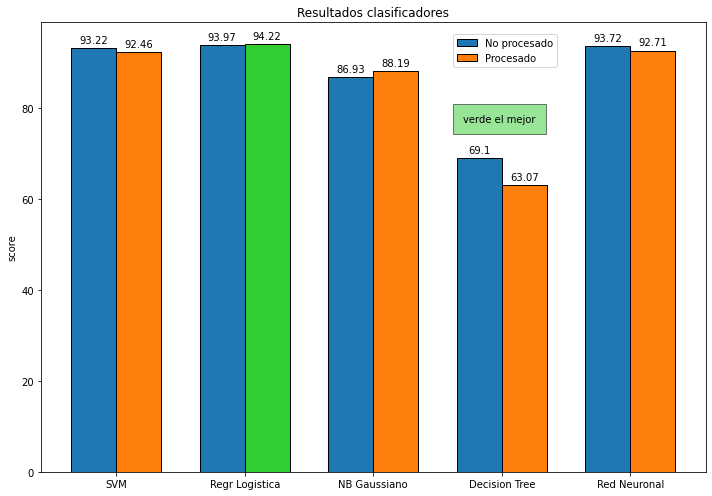

El mejor clasificador ha sido: Regr Logistica en processed
El mejor resultado ha sido score 94.22 en Regr Logistica


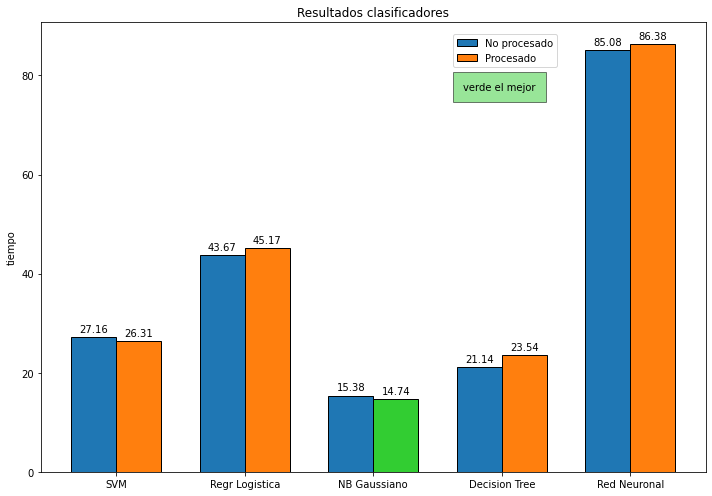

El mejor clasificador ha sido: NB Gaussiano en processed
El mejor resultado ha sido tiempo 14.74 en NB Gaussiano


In [9]:
#Graficas score
#Llamada funcion
datepath = 'resources/'+datetime.datetime.now().strftime("%d_%m_%Y_%H_%M")+'/'
best_score = graficas_resultados(score_list,path = datepath,title='score',Best='max')
best_time = graficas_resultados(time_list,path = datepath,title='tiempo',Best='min')

In [3]:
#Guardamos el mejor clasificador en disco para utilizarlo mas adelante
import pickle

# save the classifier
short_clf_names = ['SVM','RegLog','NBGauss','DecTree','RedNeu']
ds_type = '_'+Best_dataset
classifier_name = 'sign_classifier_'+short_clf_names[best_score]+ds_type+'.pkl'
try:
    open(classifier_name, 'rb')
except:
    with open(classifier_name, 'wb') as f:
        pickle.dump(Best_clf, f)

NameError: name 'Best_dataset' is not defined

## Deteccion de señales

Ahora a partir de las imagenes en Dataset_images/ vamos a crear un conjunto de imagenes tomando pequeñas imagenes 100x100 para entrenar un clasificador en este caso de tan solo 2 clases que nos permita averiguar si la imagen contiene o no una señal

Para ello vamos a obtener coger la carpeta de [Dataset_images](Dataset_images/) y vamos crear recortes de tamaño 100x100 y lo vamos a combinar con imagenes de la carpeta [Dataset_traffic_sign](Dataset_traffic_sign/)

In [4]:
def creaRecortes(recortesPorImagen,tamRecortes = 100,delete = 'yes'):
    nRecorte = 0
    ruta = 'Dataset_images/'
    pathlib.Path('cropped_images/').mkdir(parents=True, exist_ok=True)
    for i,im_path in enumerate(os.listdir(ruta)):
        imagen = cv2.imread(ruta+im_path, 0)
        for j in range(0,5):
            im_path_w = 'cropped_images/' + str(nRecorte) + '.jpg'
            if not os.path.isfile(im_path_w):
                f,c = imagen.shape #800 y 1360
                rf = np.random.randint(f-tamRecortes-1) #Valor aleatorio de fila
                rc = np.random.randint(c-tamRecortes-1) #Valor aleatorio de columna

                # rf,rc es el píxel inicial del recorte
                recorte = imagen[rf:rf+tamRecortes, rc:rc+tamRecortes]
                cv2.imwrite(im_path_w, recorte)
            nRecorte += 1

In [5]:
#Obtenemos las imagenes
creaRecortes(6)

Una vez hemos creado los recortes vamos a generar un dataset combinando las imagenes NO_SEÑAL de [cropped_images](cropped_images/) y las imagenes de la clase SEÑAL de la carpeta [Dataset_traffic_sign](Dataset_traffic_sign/)

In [6]:
rutas = ['cropped_images/','Dataset_traffic_sign/']
lista_sign = []
lista_no_sign = []
tam = 100

#SIGNS
ruta = 'Dataset_traffic_sign/'
for carpeta in os.listdir(ruta):
    #Listamos el directorio
    lista_carpeta = os.listdir(ruta+carpeta)
    #Vamos a coger la mitad de las imagenes
    len_c = int(0.415*len(lista_carpeta))
    for img in lista_carpeta[:len_c]:
#         print(ruta+carpeta+'/'+img)
        #Leemos y hacemos resize
        img = cv2.imread(ruta+carpeta+'/'+img,0)
        img = cv2.resize(img,(tam,tam))
        #Extraemos las caracteristicas con hog
        hog_img = hog(img)
        lista_sign.append(hog_img)
        
#Añadimos la columna de clase
data_sign = np.array(lista_sign)
clase_sign = np.full((data_sign.shape[0],1),1)
data_sign = np.hstack((data_sign,clase_sign))
print('Creado data_sign {}'.format(data_sign.shape))

#NON SIGNS
ruta = 'cropped_images/'
for img in os.listdir(ruta):
#     print(ruta+carpeta+'/'+img)
    #Leemos y hacemos resize
    img = cv2.imread(ruta+'/'+img,0)
    img = cv2.resize(img,(tam,tam))
    #Extraemos las caracteristicas con hog
    hog_img = hog(img)
    lista_no_sign.append(hog_img)
        
#Añadimos la columna de clase
data_no_sign = np.array(lista_no_sign)
clase_sign = np.full((data_no_sign.shape[0],1),0)
data_no_sign = np.hstack((data_no_sign,clase_sign))
print('Creado data_no_sign {}'.format(data_no_sign.shape))

data = np.vstack((data_sign,data_no_sign))
#Obtenemos x e y
X= data[:,:-1]
y= data[:,-1].reshape(-1,1)

#Creamos train y test
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=2020)
train = np.hstack((Xtrain,ytrain))
test = np.hstack((Xtest,ytest))

print('Creado data {}'.format(data.shape))
print(data.shape)

#Guardamos los datasets
pathlib.Path('dataset_detection/').mkdir(parents=True, exist_ok=True)
np.save('dataset_detection/train_signs_detection',train)
np.save('dataset_detection/test_signs_detection',train)

Creado data_sign (502, 8101)
Creado data_no_sign (500, 8101)
Creado data (1002, 8101)
(1002, 8101)


In [7]:
data = np.load('dataset_detection/train_signs_detection.npy')

In [8]:
Xtrain = data[:,:-1]
ytrain = data[:,-1]

In [9]:
ytrain

array([1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1.,
       0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1.,
       0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1.,
       1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 1., 0.